# Culture Explorer: World & European Values Survey Toolkit

This notebook delivers an end-to-end cultural analytics workspace that can be executed in Google Colab. It combines a static geopandas/matplotlib map (no JavaScript required), comparison dashboards, a pure Python helper layer, and OpenAI-powered cultural insights to satisfy the requirements outlined in the project brief.

**What you can do here:**

* Explore World Values Survey (WVS) and European Values Survey (EVS) indicators on a global map.
* Build comparison matrices for arbitrary sets of countries, fine-tuning the weight of individual survey questions through interactive controls.
* Capture retrospective and future survey measurements directly inside the notebook or via the helper service methods.
* Create family or team groups, collect their survey responses, and match their profiles to the closest countries.
* Plug in an OpenAI API key to obtain reusable cultural briefings, collaboration advice, and conflict mediation guidance from the survey scores.

> **Data**: A small representative CSV is bundled inside the repository for offline execution. In a Colab environment you can replace it with the official WVS/EVS extracts placed under the `data/` folder.


## 1. Environment setup

The following cell installs all runtime dependencies. Comment it out if you already manage packages elsewhere.

## 2. Imports and global configuration

In [2]:
import json
import hashlib
import re
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple
from itertools import groupby

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
try:
    import geopandas as gpd
except ImportError:
    gpd = None
try:
    import ipywidgets as widgets
except ImportError:
    widgets = None
from IPython.display import Markdown, display, clear_output
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import Normalize


try:
    import pdfplumber  # type: ignore
except ImportError:  # pragma: no cover - optional dependency for parsing PDF catalogues
    pdfplumber = None

DATA_DIR = Path("data")
COUNTRY_PATH = DATA_DIR / "country.csv"
LOCATION_PATH = DATA_DIR / "long_lat.csv"
QUESTION_INDEX_PATH = DATA_DIR / "question_index.json"
CACHE_PATH = DATA_DIR / "openai_response_cache.json"
QUESTION_CODE_PATTERN = re.compile(r'^([A-Za-z]+\d+[A-Za-z0-9-]*)$')

def _sanitise_column_name(name: str) -> str:
    return re.sub(r'[^a-z0-9]', '', str(name).lower())

def derive_standard_column_mapping(columns: List[str], entity_type: str) -> Dict[str, str]:
    patterns = {
        'Country': ['country', 'countryname', 'nation'],
        'ISO3': ['iso3', 'iso'],
        'Latitude': ['latitude', 'lat'],
        'Longitude': ['longitude', 'long', 'lng'],
        'Source': ['source', 'dataset', 'survey'],
        'Year': ['year'],
    }
    if entity_type == 'location':
        patterns['Area'] = ['area', 'region', 'state', 'province', 'location', 'admin', 'adminname']
    mapping: Dict[str, str] = {}
    sanitised = {col: _sanitise_column_name(col) for col in columns}
    for target, keywords in patterns.items():
        match = None
        # exact match first
        for keyword in keywords:
            for col, norm in sanitised.items():
                if norm == keyword:
                    match = col
                    break
            if match:
                break
        if not match:
            for keyword in keywords:
                for col, norm in sanitised.items():
                    if norm.endswith(keyword) or keyword in norm:
                        match = col
                        break
                if match:
                    break
        if match and target not in mapping.values():
            mapping[match] = target
    return mapping

def _looks_like_pdf(path: Path) -> bool:
    try:
        with path.open("rb") as handle:
            return handle.read(4) == b"%PDF"
    except OSError:
        return False

def find_question_catalogue(data_dir: Path) -> Optional[Path]:
    search_roots = [
        data_dir,
        Path("questions"),
        Path.cwd(),
    ]
    candidates: List[Path] = []
    for root in search_roots:
        if root.is_file():
            if root.suffix.lower() == ".pdf" or _looks_like_pdf(root):
                candidates.append(root.resolve())
            continue
        if not root.exists() or not root.is_dir():
            continue
        for candidate in root.glob("*.pdf"):
            if candidate.is_file():
                candidates.append(candidate.resolve())
        for candidate in root.glob("*"):
            if candidate.is_file() and _looks_like_pdf(candidate):
                candidates.append(candidate.resolve())
    unique_candidates: List[Path] = []
    seen: set[Path] = set()
    for candidate in candidates:
        if candidate not in seen:
            unique_candidates.append(candidate)
            seen.add(candidate)
    prioritised = [path for path in unique_candidates if "question" in path.name.lower()]
    return prioritised[0] if prioritised else (unique_candidates[0] if unique_candidates else None)

def extract_official_question_titles(pdf_path: Path) -> Dict[str, str]:
    if pdfplumber is None:
        return {}
    question_titles: Dict[str, str] = {}
    try:
        with pdfplumber.open(str(pdf_path)) as pdf:
            for page in pdf.pages:
                words = page.extract_words(use_text_flow=True, keep_blank_chars=False)
                if not words:
                    continue
                words.sort(key=lambda w: (round(w['top'], 1), w['x0']))
                for _, group in groupby(words, key=lambda w: round(w['top'], 1)):
                    row = sorted(group, key=lambda w: w['x0'])
                    idx = 0
                    while idx < len(row):
                        raw_code = row[idx]['text'].strip()
                        candidate = re.sub(r'[\s.:]+$', '', raw_code)
                        if QUESTION_CODE_PATTERN.match(candidate):
                            code = candidate
                            idx += 1
                            text_parts: List[str] = []
                            while idx < len(row):
                                next_text = row[idx]['text'].strip()
                                cleaned = re.sub(r'[\s.:]+$', '', next_text)
                                if QUESTION_CODE_PATTERN.match(cleaned):
                                    break
                                text_parts.append(next_text)
                                idx += 1
                            question = ' '.join(text_parts).strip()
                            question = re.sub(r'(?:\s+\d+)+$', '', question).strip()
                            question = re.sub(r'\s{2,}', ' ', question)
                            if question and code not in question_titles:
                                question_titles[code] = question
                        else:
                            idx += 1
    except Exception as exc:  # pragma: no cover - parsing quality depends on PDF formatting
        display(Markdown(f'⚠️ **Warning:** Unable to parse `{pdf_path.name}` for question titles ({exc}).'))
    return question_titles

def normalise_headers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(col).strip() for col in df.columns]
    return df

def ensure_required_columns(df: pd.DataFrame, entity_type: str) -> pd.DataFrame:
    df = df.copy()
    mapping = derive_standard_column_mapping(df.columns.tolist(), entity_type)
    if mapping:
        df = df.rename(columns=mapping)
    if 'Source' not in df.columns:
        df['Source'] = 'World Values Survey'
    if 'Year' not in df.columns:
        df['Year'] = pd.Timestamp.today().year
    if 'ISO3' not in df.columns:
        if 'Country' in df.columns:
            df['ISO3'] = df['Country'].astype(str).str[:3].str.upper()
        else:
            df['ISO3'] = 'UNK'
    if entity_type == 'location' and 'Area' not in df.columns:
        fallback = None
        for candidate in ['Location', 'Region', 'State', 'Province']:
            if candidate in df.columns:
                fallback = candidate
                break
        df['Area'] = df[fallback] if fallback else 'Unknown'
    return df

def summarise_spreadsheet(path: Path, titles: Dict[str, str]) -> Dict[str, object]:
    if not path.exists():
        return {"columns": [], "first_row": {}, "question_index": []}
    try:
        raw = pd.read_csv(path)
    except pd.errors.EmptyDataError:
        return {"columns": [], "first_row": {}, "question_index": []}
    raw = normalise_headers(raw)
    columns = [str(col).strip() for col in raw.columns]
    raw.columns = columns
    if raw.empty:
        first_row = {}
    else:
        sample = raw.iloc[0]
        def _convert(value: object) -> object:
            if pd.isna(value):
                return None
            if isinstance(value, np.generic):
                try:
                    return value.item()
                except Exception:
                    pass
            if hasattr(value, "item"):
                try:
                    return value.item()
                except Exception:
                    return value
            return value
        first_row = {col: _convert(sample[col]) for col in columns}
    question_index = [
        {
            "column_number": idx + 1,
            "code": col,
            "title": titles.get(col),
            "found_in_pdf": col in titles,
        }
        for idx, col in enumerate(columns)
        if QUESTION_CODE_PATTERN.match(str(col))
    ]
    return {"columns": columns, "first_row": first_row, "question_index": question_index}

def load_culture_frame(path: Path, entity_type: str, titles: Dict[str, str]) -> pd.DataFrame:
    base_columns = [
        'Country',
        'ParentCountry',
        'ISO3',
        'Latitude',
        'Longitude',
        'Year',
        'Source',
        'QuestionGroup',
        'Question',
        'QuestionCode',
        'Score',
        'EntityType',
    ]
    if entity_type == 'location':
        base_columns.append('Area')

    def _empty_frame() -> pd.DataFrame:
        frame = pd.DataFrame(columns=base_columns)
        frame['EntityType'] = entity_type
        return frame

    if not path.exists() or path.stat().st_size == 0:
        return _empty_frame()
    try:
        raw = pd.read_csv(path)
    except pd.errors.EmptyDataError:
        return _empty_frame()
    if raw.empty:
        return _empty_frame()
    raw = normalise_headers(raw)
    raw = ensure_required_columns(raw, entity_type)

    numeric_columns = ['Latitude', 'Longitude', 'Year']
    for column in numeric_columns:
        if column in raw.columns:
            raw[column] = pd.to_numeric(raw[column], errors='coerce')
    raw = raw.dropna(subset=[col for col in ['Latitude', 'Longitude', 'Year'] if col in raw.columns])
    if raw.empty:
        return _empty_frame()
    raw['Year'] = raw['Year'].astype(int)

    question_columns = [col for col in raw.columns if QUESTION_CODE_PATTERN.match(str(col))]
    if not question_columns:
        if entity_type == 'country':
            raise ValueError(
                f"No survey question columns detected in `{path.name}`. Columns must use official codes like 'A001'."
            )
        return _empty_frame()
    id_columns = [col for col in raw.columns if col not in question_columns]

    melted = raw.melt(id_vars=id_columns, value_vars=question_columns, var_name='QuestionCode', value_name='Score')
    melted['Score'] = pd.to_numeric(melted['Score'], errors='coerce')
    melted = melted.dropna(subset=['Score', 'Latitude', 'Longitude', 'Year'])
    if melted.empty:
        return _empty_frame()
    melted['Score'] = melted['Score'].astype(float)

    melted['QuestionCode'] = melted['QuestionCode'].astype(str)
    melted['QuestionGroup'] = (
        melted['QuestionCode'].str.extract(r'^([A-Za-z]+)', expand=False).str.upper().fillna('GENERAL')
    )
    melted['Question'] = [titles.get(code, code) for code in melted['QuestionCode']]
    melted['EntityType'] = entity_type

    if entity_type == 'country':
        melted['ParentCountry'] = melted['Country'].astype(str)
        melted['DisplayName'] = melted['Country'].astype(str)
    else:
        area_column = None
        for candidate in ['Area', 'Region', 'Location', 'State', 'Province']:
            if candidate in melted.columns:
                area_column = candidate
                break
        if area_column is None:
            melted['Area'] = melted['Country'].astype(str)
            area_column = 'Area'
        melted['ParentCountry'] = melted['Country'].astype(str)
        melted['DisplayName'] = (
            melted[area_column].astype(str).str.strip() + ' — ' + melted['ParentCountry'].astype(str).str.strip()
        )
        melted['Country'] = melted['DisplayName']

    if 'ISO3' not in melted.columns:
        base = melted.get('ParentCountry', melted.get('Country'))
        melted['ISO3'] = base.astype(str).str[:3].str.upper() if base is not None else 'UNK'

    columns = [
        'Country',
        'ParentCountry',
        'ISO3',
        'Latitude',
        'Longitude',
        'Year',
        'Source',
        'QuestionGroup',
        'Question',
        'QuestionCode',
        'Score',
        'EntityType',
    ]
    if 'Area' in melted.columns:
        columns.append('Area')

    melted = melted[[col for col in columns if col in melted.columns]].copy()
    melted['Country'] = melted['Country'].astype(str)
    melted['ParentCountry'] = melted['ParentCountry'].astype(str)
    return melted.reset_index(drop=True)

QUESTION_PDF = find_question_catalogue(DATA_DIR)
OFFICIAL_TITLES = extract_official_question_titles(QUESTION_PDF) if QUESTION_PDF else {}

if not CACHE_PATH.exists():
    CACHE_PATH.write_text("{}", encoding="utf-8")

country_records = load_culture_frame(COUNTRY_PATH, "country", OFFICIAL_TITLES)
location_records = load_culture_frame(LOCATION_PATH, "location", OFFICIAL_TITLES)

country_summary = summarise_spreadsheet(COUNTRY_PATH, OFFICIAL_TITLES)
location_summary = summarise_spreadsheet(LOCATION_PATH, OFFICIAL_TITLES)

COLUMN_SUMMARIES = {
    "country": {"columns": country_summary["columns"], "first_row": country_summary["first_row"]},
    "location": {"columns": location_summary["columns"], "first_row": location_summary["first_row"]},
}
QUESTION_INDEX = {
    "country": country_summary["question_index"],
    "location": location_summary["question_index"],
}


QUESTION_INDEX_PATH.write_text(
    json.dumps(QUESTION_INDEX, indent=2, ensure_ascii=False),
    encoding="utf-8",
)

display(
    Markdown(
        "\n".join(
            [
                f"Loaded **{len(country_records)}** country-level responses from `{COUNTRY_PATH.name}` covering **{country_records['Country'].nunique()}** countries.",
                f"Loaded **{len(location_records)}** local observations from `{LOCATION_PATH.name}` across **{location_records['Country'].nunique()}** areas.",
                "Mapped question codes to official titles." if OFFICIAL_TITLES else "Using question codes directly (no PDF detected).",
            ]
        )
    )
)

if country_summary["columns"]:
    display(Markdown("**Country data — first row preview (first 10 columns):**"))
    preview_cols = country_summary["columns"][:10]
    display(pd.DataFrame([country_summary["first_row"]])[preview_cols])

if QUESTION_INDEX["country"]:
    display(Markdown("**Sample question index mapping (country data):**"))
    display(pd.DataFrame(QUESTION_INDEX["country"]).head())

country_records.head()
location_records.head()
QuestionKey = Tuple[str, str]


class CulturalDataset:
    """Convenience wrapper around country and location survey records."""

    required_columns = {
        "Country",
        "ParentCountry",
        "ISO3",
        "Latitude",
        "Longitude",
        "Year",
        "Source",
        "QuestionGroup",
        "Question",
        "QuestionCode",
        "Score",
        "EntityType",
    }

    def __init__(self, country_df: pd.DataFrame, location_df: pd.DataFrame):
        self._validate_input("country", country_df)
        self._validate_input("location", location_df)
        self.country_data = country_df.copy()
        self.location_data = location_df.copy()
        self.data = self.country_data.copy()
        self.base_countries = sorted(self.country_data["Country"].unique())
        self.location_lookup = {
            name: group.copy() for name, group in self.location_data.groupby("Country")
        }
        self.question_lookup: Dict[QuestionKey, str] = {}
        combined = pd.concat([self.country_data, self.location_data], ignore_index=True)
        for _, row in (
            combined[["QuestionGroup", "Question", "QuestionCode"]]
            .drop_duplicates()
            .iterrows()
        ):
            self.question_lookup[(row["QuestionGroup"], row["Question"])] = row["QuestionCode"]
        self._refresh_metadata()

    def _validate_input(self, label: str, frame: pd.DataFrame) -> None:
        missing = self.required_columns - set(frame.columns)
        if missing:
            raise ValueError(f"{label.capitalize()} data is missing required columns: {missing}")

    def _refresh_metadata(self) -> None:
        records: List[pd.DataFrame] = []
        for frame in [self.country_data, self.location_data]:
            if frame.empty:
                continue
            meta = (
                frame.groupby("Country")
                .agg(
                    Latitude=("Latitude", "mean"),
                    Longitude=("Longitude", "mean"),
                    ParentCountry=("ParentCountry", "first"),
                    EntityType=("EntityType", "first"),
                )
                .reset_index()
            )
            records.append(meta)
        if records:
            combined = (
                pd.concat(records, ignore_index=True)
                .drop_duplicates("Country", keep="first")
            )
            self.metadata = {row["Country"]: row.to_dict() for _, row in combined.iterrows()}
        else:
            self.metadata = {}
        self.available_entities = sorted(self.data["Country"].unique())

    def get_countries(self) -> List[str]:
        return self.available_entities.copy()

    def get_locations(self) -> List[str]:
        return sorted(self.location_data["Country"].unique())

    def get_years(self) -> List[int]:
        years = self.data["Year"].unique().tolist()
        return sorted(int(year) for year in years)

    def get_group_questions(self) -> Dict[str, List[str]]:
        grouped = self.data.groupby("QuestionGroup")["Question"].unique()
        return {group: sorted(values.tolist()) for group, values in grouped.items()}


    def get_sources(self) -> List[str]:
        return sorted(self.data["Source"].unique())

    def get_question_code(self, group: str, question: str) -> str:
        return self.question_lookup.get((group, question), question)

    def filter_records(self, countries: Iterable[str], year: int) -> pd.DataFrame:
        country_list = list(countries)
        filtered = self.data[
            self.data["Country"].isin(country_list) & (self.data["Year"] == year)
        ]
        if filtered.empty:
            raise ValueError(
                "No records match the current filter. Try a different year or entity selection."
            )
        return filtered

    def get_question_matrix(
        self, countries: Iterable[str], year: int, group: Optional[str] = None
    ) -> pd.DataFrame:
        subset = self.filter_records(countries, year)
        if group and group != "All Groups":
            subset = subset[subset["QuestionGroup"] == group]
        matrix = subset.pivot_table(index="Question", columns="Country", values="Score")
        return matrix.sort_index()

    def compute_weighted_group_scores(
        self, countries: Iterable[str], year: int, weights: Dict[QuestionKey, float]
    ) -> pd.DataFrame:
        subset = self.filter_records(countries, year).copy()
        subset["Weight"] = subset.apply(
            lambda row: float(weights.get((row["QuestionGroup"], row["Question"]), 1.0)),
            axis=1,
        )
        subset["WeightedScore"] = subset["Score"] * subset["Weight"]

        def safe_mean(group_df: pd.DataFrame) -> float:
            weight_sum = group_df["Weight"].sum()
            if weight_sum == 0:
                return float("nan")
            return group_df["WeightedScore"].sum() / weight_sum

        aggregated = (
            subset.groupby(["Country", "QuestionGroup"], group_keys=False)
            .apply(safe_mean, include_groups=False)
            .unstack("QuestionGroup")
        )
        return aggregated

    def ensure_entity_available(self, entity_name: str, entity_type: str = "country") -> None:
        if entity_name in self.available_entities:
            return
        if entity_type == "location":
            if entity_name not in self.location_lookup:
                raise ValueError(f"Unknown location '{entity_name}'.")
            self.data = pd.concat([self.data, self.location_lookup[entity_name]], ignore_index=True)
        else:
            raise ValueError(f"Unknown entity '{entity_name}'.")
        self._refresh_metadata()

    def get_map_view(
        self, entity_type: str, year: int, question_group: str, question: str
    ) -> pd.DataFrame:
        frame = self.country_data if entity_type == "country" else self.location_data
        subset = frame[
            (frame["Year"] == year)
            & (frame["QuestionGroup"] == question_group)
            & (frame["Question"] == question)
        ][[
            "Country",
            "ParentCountry",
            "ISO3",
            "Latitude",
            "Longitude",
            "Year",
            "Source",
            "QuestionGroup",
            "Question",
            "Score",
            "EntityType",
        ]]
        return subset.reset_index(drop=True)

    def get_entity_profile(
        self, entity_name: str, entity_type: str, year: int
    ) -> pd.DataFrame:
        frame = self.country_data if entity_type == "country" else self.location_data
        subset = frame[(frame["Country"] == entity_name) & (frame["Year"] == year)]
        return subset[["QuestionGroup", "Question", "Score"]]


class GroupManager:
    def __init__(self, dataset: CulturalDataset):
        self.dataset = dataset
        self.groups: Dict[str, Dict[str, object]] = {}

    def _validate_responses(self, responses: Dict[QuestionKey, float]) -> None:
        valid_questions = self.dataset.get_group_questions()
        for (group, question), value in responses.items():
            if group not in valid_questions:
                raise ValueError(f"Unknown question group: {group}")
            if question not in valid_questions[group]:
                raise ValueError(f"Unknown question '{question}' for group '{group}'.")
            if not (0.0 <= value <= 1.0):
                raise ValueError("Scores must be normalised between 0 and 1.")

    def add_member(
        self,
        group_name: str,
        member_name: str,
        responses: Dict[QuestionKey, float],
        group_type: str = "team",
        reference_year: Optional[int] = None,
    ) -> None:
        group_name = group_name.strip()
        if not group_name:
            raise ValueError("Group name cannot be empty.")
        if not member_name.strip():
            raise ValueError("Member name cannot be empty.")
        self._validate_responses(responses)
        record = self.groups.setdefault(
            group_name,
            {
                "type": group_type,
                "members": {},
                "reference_year": reference_year,
            },
        )
        record["members"][member_name] = responses
        if reference_year is not None:
            record["reference_year"] = reference_year

    def get_group_members(self, group_name: str) -> Dict[str, Dict[QuestionKey, float]]:
        group = self.groups.get(group_name)
        if not group:
            raise KeyError(f"Group '{group_name}' not found.")
        return group["members"]  # type: ignore[return-value]

    def compute_group_profile(self, group_name: str) -> pd.Series:
        members = self.get_group_members(group_name)
        if not members:
            raise ValueError("Group has no members recorded yet.")
        df = pd.DataFrame(members).T
        profile = df.mean(axis=0)
        profile.name = group_name
        return profile

    def reference_year(self, group_name: str) -> Optional[int]:
        group = self.groups.get(group_name)
        return group.get("reference_year") if group else None  # type: ignore[return-value]

    def match_closest_country(
        self, group_name: str, year: Optional[int] = None
    ) -> pd.DataFrame:
        profile = self.compute_group_profile(group_name)
        question_pairs = list(profile.index)
        year = year or self.reference_year(group_name) or max(self.dataset.get_years())
        entities = self.dataset.get_countries()
        subset = self.dataset.filter_records(entities, year)
        subset = subset[
            subset.apply(
                lambda row: (row["QuestionGroup"], row["Question"]) in question_pairs,
                axis=1,
            )
        ]
        matrix = subset.pivot_table(
            index="Country", columns=["QuestionGroup", "Question"], values="Score"
        )

        def distance(row: pd.Series) -> float:
            diff = row - profile
            diff = diff.fillna(diff.mean())
            return float(np.sqrt((diff**2).sum()))

        scores = matrix.apply(distance, axis=1).sort_values()
        result = scores.to_frame(name="EuclideanDistance")
        result["Similarity (lower is better)"] = result["EuclideanDistance"]
        return result


class OpenAIInsightGenerator:
    prompt_templates = {
        "question_basis": (
            "You are a cultural analyst. Explain why communities scoring {score} on "
            "'{question}'\nfrom the {source} might interpret situations in that way. "
            "Keep the answer under 250 words."
        ),
        "situation_lens": (
            "Given the cultural score(s) {scores} from the {source}, describe the "
            "likely lens through\nwhich a person would interpret the following "
            "situation: {situation}. Limit to 250 words."
        ),
        "score_delta": (
            "Compare scores {score_a} and {score_b} from the {source}. Explain why "
            "these perspectives might clash or align and provide actionable advice "
            "in under 200 words."
        ),
        "collaboration": (
            "Two or more people have scores {scores} from the {source}. Provide "
            "practical guidance on how they can work together effectively. 200 words "
            "maximum."
        ),
        "family": (
            "Family members with cultural profile {scores} from the {source} are "
            "seeking harmony. Offer strategies to improve their dynamics in under "
            "200 words."
        ),
    }

    def __init__(self, cache_path: Path):
        self.cache_path = cache_path
        try:
            self.cache: Dict[str, str] = json.loads(cache_path.read_text(encoding="utf-8"))
        except json.JSONDecodeError:
            self.cache = {}
        self.client: Optional[OpenAI] = None
        self.api_key: Optional[str] = None

    def set_api_key(self, api_key: str) -> None:
        if OpenAI is None:  # pragma: no cover - exercised only when dependency missing
            raise ImportError("The openai package is not installed.")
        self.api_key = api_key
        self.client = OpenAI(api_key=api_key)

    def _cache_key(self, prompt: str) -> str:
        return hashlib.sha256(prompt.encode("utf-8")).hexdigest()

    def _render_prompt(self, template_key: str, **kwargs) -> str:
        if template_key not in self.prompt_templates:
            raise KeyError(f"Unknown template '{template_key}'")
        prompt = self.prompt_templates[template_key].format(**kwargs)
        prompt += "\n\nDo not request or rely on personal data."
        return prompt

    def generate(self, template_key: str, **kwargs) -> str:
        prompt = self._render_prompt(template_key, **kwargs)
        cache_key = self._cache_key(prompt)
        if cache_key in self.cache:
            return self.cache[cache_key]
        if self.client is None:
            return "OpenAI client not configured. Set your API key before generating insights."
        response = self.client.responses.create(  # pragma: no cover - network interaction
            model="gpt-4o-mini",
            input=[{"role": "user", "content": prompt}],
            max_output_tokens=500,
        )
        message = response.output_text.strip()
        self.cache[cache_key] = message
        self.cache_path.write_text(json.dumps(self.cache, indent=2), encoding="utf-8")
        return message


class CultureExplorerService:
    """Backend helper used by the notebook and unit tests."""

    def __init__(
        self,
        dataset: CulturalDataset,
        group_manager: GroupManager,
        insight_generator: OpenAIInsightGenerator,
    ) -> None:
        self.dataset = dataset
        self.group_manager = group_manager
        self.insight_generator = insight_generator

    def get_countries(self) -> List[str]:
        return self.dataset.get_countries()

    def get_years(self) -> List[int]:
        return self.dataset.get_years()

    def get_group_questions(self) -> Dict[str, List[str]]:
        return self.dataset.get_group_questions()
    def get_score_matrix(
        self, countries: List[str], year: int, group: Optional[str] = None
    ) -> pd.DataFrame:
        return self.dataset.get_question_matrix(countries, year, group)


    def ensure_location_available(self, location: str) -> None:
        self.dataset.ensure_entity_available(location, "location")

    def add_group_member(
        self,
        group_name: str,
        member_name: str,
        responses: Dict[QuestionKey, float],
        group_type: str = "team",
        reference_year: Optional[int] = None,
    ) -> None:
        self.group_manager.add_member(
            group_name,
            member_name,
            responses,
            group_type=group_type,
            reference_year=reference_year,
        )

    def match_group_to_country(
        self, group_name: str, year: Optional[int] = None
    ) -> pd.DataFrame:
        return self.group_manager.match_closest_country(group_name, year=year)


def add_future_record(
    dataset: CulturalDataset,
    country: str,
    iso3: str,
    latitude: float,
    longitude: float,
    year: int,
    source: str,
    question_group: str,
    question: str,
    score: float,
    entity_type: str = "country",
) -> None:
    if not (0.0 <= score <= 1.0):
        raise ValueError("Score must be between 0 and 1 inclusive.")
    record = pd.DataFrame(
        [
            {
                "Country": country,
                "ParentCountry": country if entity_type == "country" else country,
                "ISO3": iso3,
                "Latitude": latitude,
                "Longitude": longitude,
                "Year": year,
                "Source": source,
                "QuestionGroup": question_group,
                "Question": question,
                "QuestionCode": dataset.get_question_code(question_group, question),
                "Score": score,
                "EntityType": entity_type,
            }
        ]
    )
    if entity_type == "country":
        dataset.country_data = pd.concat([dataset.country_data, record], ignore_index=True)
        dataset.data = dataset.country_data.copy()
    elif entity_type == "location":
        dataset.location_data = pd.concat([dataset.location_data, record], ignore_index=True)
        dataset.location_lookup[country] = dataset.location_data[
            dataset.location_data["Country"] == country
        ]
    else:
        raise ValueError(f"Unsupported entity type '{entity_type}'.")
    dataset._refresh_metadata()


__all__ = [
    "CulturalDataset",
    "GroupManager",
    "OpenAIInsightGenerator",
    "CultureExplorerService",
    "add_future_record",
]



from typing import Tuple

import matplotlib.pyplot as plt
import pandas as pd


_WORLD_URL = 'https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip'


def _load_world() -> gpd.GeoDataFrame:
    cache_dir = Path.home() / '.cache' / 'culture_explorer'
    cache_dir.mkdir(parents=True, exist_ok=True)
    archive = cache_dir / 'ne_110m_admin_0_countries.zip'
    if not archive.exists():
        try:
            import urllib.request

            urllib.request.urlretrieve(_WORLD_URL, archive)
        except Exception as exc:  # pragma: no cover - network failures
            raise RuntimeError(
                'Unable to download Natural Earth shapefile. '
                'Please download the archive manually and place it at ' + str(archive)
            ) from exc
    return gpd.read_file(archive)


_WORLD = None  # loaded lazily


def _ensure_world() -> "gpd.GeoDataFrame":
    if gpd is None:
        raise ImportError("geopandas is required for map rendering.")
    global _WORLD
    if _WORLD is None:
        _WORLD = _load_world()
    return _WORLD


def _merge_world_scores(world: gpd.GeoDataFrame, scores: pd.DataFrame) -> gpd.GeoDataFrame:
    merged = world.merge(scores, left_on="ISO_A3", right_on="ISO3", how="left")
    return merged


def render_static_culture_map(
    dataset: CulturalDataset,
    year: int,
    question_group: str,
    question: str,
    *,
    include_locations: bool = True,
    ax: Axes | None = None,
) -> Tuple[Figure, Axes]:
    """Render a static matplotlib map with geopandas, free from JavaScript."""

    country_df = dataset.get_map_view("country", year, question_group, question)
    location_df = dataset.get_map_view("location", year, question_group, question)

    if country_df.empty and location_df.empty:
        raise ValueError("No data available for the selected question and year.")

    base_scores = country_df[["ISO3", "Score", "Country"]].copy()
    world_scores = _merge_world_scores(_ensure_world(), base_scores)

    fig, ax = plt.subplots(figsize=(12, 6)) if ax is None else (ax.figure, ax)
    norm = Normalize(vmin=0, vmax=1)
    world_scores.plot(
        column="Score",
        cmap="viridis",
        linewidth=0.5,
        edgecolor="white",
        legend=True,
        ax=ax,
        norm=norm,
        missing_kwds={"color": "#f0f0f0", "edgecolor": "white", "label": "No data"},
    )

    if include_locations and not location_df.empty:
        sc = ax.scatter(
            location_df["Longitude"],
            location_df["Latitude"],
            c=location_df["Score"],
            cmap="viridis",
            s=40,
            norm=norm,
            edgecolor="black",
            linewidth=0.5,
            alpha=0.8,
            label="Local observations",
        )
        if "Local observations" not in [t.get_text() for t in ax.legend_.texts] if ax.legend_ else True:
            ax.legend(loc="lower left")

    ax.set_title(f"{question} — {question_group} ({year})", fontsize=14)
    ax.set_axis_off()

    if not country_df.empty:
        top = country_df.nlargest(3, "Score")[["Country", "Score"]]
        bottom = country_df.nsmallest(3, "Score")[["Country", "Score"]]
        summary_lines = ["Top countries:"]
        summary_lines.extend(
            f"  • {row.Country}: {row.Score:.2f}" for row in top.itertuples()
        )
        summary_lines.append("Lowest countries:")
        summary_lines.extend(
            f"  • {row.Country}: {row.Score:.2f}" for row in bottom.itertuples()
        )
        ax.text(
            1.02,
            0.5,
            "\n".join(summary_lines),
            transform=ax.transAxes,
            va="center",
            fontsize=10,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

    fig.tight_layout()
    return fig, ax


__all__ = ["render_static_culture_map"]
QuestionKey = Tuple[str, str]


class CulturalDataset:
    """Convenience wrapper around country and location survey records."""

    required_columns = {
        "Country",
        "ParentCountry",
        "ISO3",
        "Latitude",
        "Longitude",
        "Year",
        "Source",
        "QuestionGroup",
        "Question",
        "QuestionCode",
        "Score",
        "EntityType",
    }

    def __init__(self, country_df: pd.DataFrame, location_df: pd.DataFrame):
        self._validate_input("country", country_df)
        self._validate_input("location", location_df)
        self.country_data = country_df.copy()
        self.location_data = location_df.copy()
        self.data = self.country_data.copy()
        self.base_countries = sorted(self.country_data["Country"].unique())
        self.location_lookup = {
            name: group.copy() for name, group in self.location_data.groupby("Country")
        }
        self.question_lookup: Dict[QuestionKey, str] = {}
        combined = pd.concat([self.country_data, self.location_data], ignore_index=True)
        for _, row in (
            combined[["QuestionGroup", "Question", "QuestionCode"]]
            .drop_duplicates()
            .iterrows()
        ):
            self.question_lookup[(row["QuestionGroup"], row["Question"])] = row["QuestionCode"]
        self._refresh_metadata()

    def _validate_input(self, label: str, frame: pd.DataFrame) -> None:
        missing = self.required_columns - set(frame.columns)
        if missing:
            raise ValueError(f"{label.capitalize()} data is missing required columns: {missing}")

    def _refresh_metadata(self) -> None:
        records: List[pd.DataFrame] = []
        for frame in [self.country_data, self.location_data]:
            if frame.empty:
                continue
            meta = (
                frame.groupby("Country")
                .agg(
                    Latitude=("Latitude", "mean"),
                    Longitude=("Longitude", "mean"),
                    ParentCountry=("ParentCountry", "first"),
                    EntityType=("EntityType", "first"),
                )
                .reset_index()
            )
            records.append(meta)
        if records:
            combined = (
                pd.concat(records, ignore_index=True)
                .drop_duplicates("Country", keep="first")
            )
            self.metadata = {row["Country"]: row.to_dict() for _, row in combined.iterrows()}
        else:
            self.metadata = {}
        self.available_entities = sorted(self.data["Country"].unique())

    def get_countries(self) -> List[str]:
        return self.available_entities.copy()

    def get_locations(self) -> List[str]:
        return sorted(self.location_data["Country"].unique())

    def get_years(self) -> List[int]:
        years = self.data["Year"].unique().tolist()
        return sorted(int(year) for year in years)

    def get_group_questions(self) -> Dict[str, List[str]]:
        grouped = self.data.groupby("QuestionGroup")["Question"].unique()
        return {group: sorted(values.tolist()) for group, values in grouped.items()}

    def get_sources(self) -> List[str]:
        return sorted(self.data["Source"].unique())

    def get_question_code(self, group: str, question: str) -> str:
        return self.question_lookup.get((group, question), question)

    def filter_records(self, countries: Iterable[str], year: int) -> pd.DataFrame:
        country_list = list(countries)
        filtered = self.data[
            self.data["Country"].isin(country_list) & (self.data["Year"] == year)
        ]
        if filtered.empty:
            raise ValueError(
                "No records match the current filter. Try a different year or entity selection."
            )
        return filtered

    def get_question_matrix(
        self, countries: Iterable[str], year: int, group: Optional[str] = None
    ) -> pd.DataFrame:
        subset = self.filter_records(countries, year)
        if group and group != "All Groups":
            subset = subset[subset["QuestionGroup"] == group]
        matrix = subset.pivot_table(index="Question", columns="Country", values="Score")
        return matrix.sort_index()

    def compute_weighted_group_scores(
        self, countries: Iterable[str], year: int, weights: Dict[QuestionKey, float]
    ) -> pd.DataFrame:
        subset = self.filter_records(countries, year).copy()
        subset["Weight"] = subset.apply(
            lambda row: float(weights.get((row["QuestionGroup"], row["Question"]), 1.0)),
            axis=1,
        )
        subset["WeightedScore"] = subset["Score"] * subset["Weight"]

        def safe_mean(group_df: pd.DataFrame) -> float:
            weight_sum = group_df["Weight"].sum()
            if weight_sum == 0:
                return float("nan")
            return group_df["WeightedScore"].sum() / weight_sum

        aggregated = (
            subset.groupby(["Country", "QuestionGroup"], group_keys=False)
            .apply(safe_mean, include_groups=False)
            .unstack("QuestionGroup")
        )
        return aggregated

    def ensure_entity_available(self, entity_name: str, entity_type: str = "country") -> None:
        if entity_name in self.available_entities:
            return
        if entity_type == "location":
            if entity_name not in self.location_lookup:
                raise ValueError(f"Unknown location '{entity_name}'.")
            self.data = pd.concat([self.data, self.location_lookup[entity_name]], ignore_index=True)
        else:
            raise ValueError(f"Unknown entity '{entity_name}'.")
        self._refresh_metadata()

    def get_map_view(
        self, entity_type: str, year: int, question_group: str, question: str
    ) -> pd.DataFrame:
        frame = self.country_data if entity_type == "country" else self.location_data
        subset = frame[
            (frame["Year"] == year)
            & (frame["QuestionGroup"] == question_group)
            & (frame["Question"] == question)
        ][[
            "Country",
            "ParentCountry",
            "ISO3",
            "Latitude",
            "Longitude",
            "Year",
            "Source",
            "QuestionGroup",
            "Question",
            "Score",
            "EntityType",
        ]]
        return subset.reset_index(drop=True)

    def get_entity_profile(
        self, entity_name: str, entity_type: str, year: int
    ) -> pd.DataFrame:
        frame = self.country_data if entity_type == "country" else self.location_data
        subset = frame[(frame["Country"] == entity_name) & (frame["Year"] == year)]
        return subset[["QuestionGroup", "Question", "Score"]]


class GroupManager:
    def __init__(self, dataset: CulturalDataset):
        self.dataset = dataset
        self.groups: Dict[str, Dict[str, object]] = {}

    def _validate_responses(self, responses: Dict[QuestionKey, float]) -> None:
        valid_questions = self.dataset.get_group_questions()
        for (group, question), value in responses.items():
            if group not in valid_questions:
                raise ValueError(f"Unknown question group: {group}")
            if question not in valid_questions[group]:
                raise ValueError(f"Unknown question '{question}' for group '{group}'.")
            if not (0.0 <= value <= 1.0):
                raise ValueError("Scores must be normalised between 0 and 1.")

    def add_member(
        self,
        group_name: str,
        member_name: str,
        responses: Dict[QuestionKey, float],
        group_type: str = "team",
        reference_year: Optional[int] = None,
    ) -> None:
        group_name = group_name.strip()
        if not group_name:
            raise ValueError("Group name cannot be empty.")
        if not member_name.strip():
            raise ValueError("Member name cannot be empty.")
        self._validate_responses(responses)
        record = self.groups.setdefault(
            group_name,
            {
                "type": group_type,
                "members": {},
                "reference_year": reference_year,
            },
        )
        record["members"][member_name] = responses
        if reference_year is not None:
            record["reference_year"] = reference_year

    def get_group_members(self, group_name: str) -> Dict[str, Dict[QuestionKey, float]]:
        group = self.groups.get(group_name)
        if not group:
            raise KeyError(f"Group '{group_name}' not found.")
        return group["members"]  # type: ignore[return-value]

    def compute_group_profile(self, group_name: str) -> pd.Series:
        members = self.get_group_members(group_name)
        if not members:
            raise ValueError("Group has no members recorded yet.")
        df = pd.DataFrame(members).T
        profile = df.mean(axis=0)
        profile.name = group_name
        return profile

    def reference_year(self, group_name: str) -> Optional[int]:
        group = self.groups.get(group_name)
        return group.get("reference_year") if group else None  # type: ignore[return-value]

    def match_closest_country(
        self, group_name: str, year: Optional[int] = None
    ) -> pd.DataFrame:
        profile = self.compute_group_profile(group_name)
        question_pairs = list(profile.index)
        year = year or self.reference_year(group_name) or max(self.dataset.get_years())
        entities = self.dataset.get_countries()
        subset = self.dataset.filter_records(entities, year)
        subset = subset[
            subset.apply(
                lambda row: (row["QuestionGroup"], row["Question"]) in question_pairs,
                axis=1,
            )
        ]
        matrix = subset.pivot_table(
            index="Country", columns=["QuestionGroup", "Question"], values="Score"
        )

        def distance(row: pd.Series) -> float:
            diff = row - profile
            diff = diff.fillna(diff.mean())
            return float(np.sqrt((diff**2).sum()))

        scores = matrix.apply(distance, axis=1).sort_values()
        result = scores.to_frame(name="EuclideanDistance")
        result["Similarity (lower is better)"] = result["EuclideanDistance"]
        return result


class OpenAIInsightGenerator:
    prompt_templates = {
        "question_basis": (
            "You are a cultural analyst. Explain why communities scoring {score} on "
            "'{question}'\nfrom the {source} might interpret situations in that way. "
            "Keep the answer under 250 words."
        ),
        "situation_lens": (
            "Given the cultural score(s) {scores} from the {source}, describe the "
            "likely lens through\nwhich a person would interpret the following "
            "situation: {situation}. Limit to 250 words."
        ),
        "score_delta": (
            "Compare scores {score_a} and {score_b} from the {source}. Explain why "
            "these perspectives might clash or align and provide actionable advice "
            "in under 200 words."
        ),
        "collaboration": (
            "Two or more people have scores {scores} from the {source}. Provide "
            "practical guidance on how they can work together effectively. 200 words "
            "maximum."
        ),
        "family": (
            "Family members with cultural profile {scores} from the {source} are "
            "seeking harmony. Offer strategies to improve their dynamics in under "
            "200 words."
        ),
    }

    def __init__(self, cache_path: Path):
        self.cache_path = cache_path
        try:
            self.cache: Dict[str, str] = json.loads(cache_path.read_text(encoding="utf-8"))
        except json.JSONDecodeError:
            self.cache = {}
        self.client: Optional[OpenAI] = None
        self.api_key: Optional[str] = None

    def set_api_key(self, api_key: str) -> None:
        if OpenAI is None:  # pragma: no cover - exercised only when dependency missing
            raise ImportError("The openai package is not installed.")
        self.api_key = api_key
        self.client = OpenAI(api_key=api_key)

    def _cache_key(self, prompt: str) -> str:
        return hashlib.sha256(prompt.encode("utf-8")).hexdigest()

    def _render_prompt(self, template_key: str, **kwargs) -> str:
        if template_key not in self.prompt_templates:
            raise KeyError(f"Unknown template '{template_key}'")
        prompt = self.prompt_templates[template_key].format(**kwargs)
        prompt += "\n\nDo not request or rely on personal data."
        return prompt

    def generate(self, template_key: str, **kwargs) -> str:
        prompt = self._render_prompt(template_key, **kwargs)
        cache_key = self._cache_key(prompt)
        if cache_key in self.cache:
            return self.cache[cache_key]
        if self.client is None:
            return "OpenAI client not configured. Set your API key before generating insights."
        response = self.client.responses.create(  # pragma: no cover - network interaction
            model="gpt-4o-mini",
            input=[{"role": "user", "content": prompt}],
            max_output_tokens=500,
        )
        message = response.output_text.strip()
        self.cache[cache_key] = message
        self.cache_path.write_text(json.dumps(self.cache, indent=2), encoding="utf-8")
        return message


class CultureExplorerService:
    """Backend helper used by the notebook and unit tests."""

    def __init__(
        self,
        dataset: CulturalDataset,
        group_manager: GroupManager,
        insight_generator: OpenAIInsightGenerator,
    ) -> None:
        self.dataset = dataset
        self.group_manager = group_manager
        self.insight_generator = insight_generator

    def get_countries(self) -> List[str]:
        return self.dataset.get_countries()

    def get_years(self) -> List[int]:
        return self.dataset.get_years()

    def get_group_questions(self) -> Dict[str, List[str]]:
        return self.dataset.get_group_questions()

    def ensure_location_available(self, location: str) -> None:
        self.dataset.ensure_entity_available(location, "location")

    def add_group_member(
        self,
        group_name: str,
        member_name: str,
        responses: Dict[QuestionKey, float],
        group_type: str = "team",
        reference_year: Optional[int] = None,
    ) -> None:
        self.group_manager.add_member(
            group_name,
            member_name,
            responses,
            group_type=group_type,
            reference_year=reference_year,
        )

    def match_group_to_country(
        self, group_name: str, year: Optional[int] = None
    ) -> pd.DataFrame:
        return self.group_manager.match_closest_country(group_name, year=year)


def add_future_record(
    dataset: CulturalDataset,
    country: str,
    iso3: str,
    latitude: float,
    longitude: float,
    year: int,
    source: str,
    question_group: str,
    question: str,
    score: float,
    entity_type: str = "country",
) -> None:
    if not (0.0 <= score <= 1.0):
        raise ValueError("Score must be between 0 and 1 inclusive.")
    record = pd.DataFrame(
        [
            {
                "Country": country,
                "ParentCountry": country if entity_type == "country" else country,
                "ISO3": iso3,
                "Latitude": latitude,
                "Longitude": longitude,
                "Year": year,
                "Source": source,
                "QuestionGroup": question_group,
                "Question": question,
                "QuestionCode": dataset.get_question_code(question_group, question),
                "Score": score,
                "EntityType": entity_type,
            }
        ]
    )
    if entity_type == "country":
        dataset.country_data = pd.concat([dataset.country_data, record], ignore_index=True)
        dataset.data = dataset.country_data.copy()
    elif entity_type == "location":
        dataset.location_data = pd.concat([dataset.location_data, record], ignore_index=True)
        dataset.location_lookup[country] = dataset.location_data[
            dataset.location_data["Country"] == country
        ]
    else:
        raise ValueError(f"Unsupported entity type '{entity_type}'.")
    dataset._refresh_metadata()


__all__ = [
    "CulturalDataset",
    "GroupManager",
    "OpenAIInsightGenerator",
    "CultureExplorerService",
    "add_future_record",
]



from typing import Tuple

import matplotlib.pyplot as plt
import pandas as pd


_WORLD_URL = 'https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip'


def _load_world() -> gpd.GeoDataFrame:
    cache_dir = Path.home() / '.cache' / 'culture_explorer'
    cache_dir.mkdir(parents=True, exist_ok=True)
    archive = cache_dir / 'ne_110m_admin_0_countries.zip'
    if not archive.exists():
        try:
            import urllib.request

            urllib.request.urlretrieve(_WORLD_URL, archive)
        except Exception as exc:  # pragma: no cover - network failures
            raise RuntimeError(
                'Unable to download Natural Earth shapefile. '
                'Please download the archive manually and place it at ' + str(archive)
            ) from exc
    return gpd.read_file(archive)


_WORLD = None  # loaded lazily


def _merge_world_scores(world: gpd.GeoDataFrame, scores: pd.DataFrame) -> gpd.GeoDataFrame:
    merged = world.merge(scores, left_on="ISO_A3", right_on="ISO3", how="left")
    return merged


def render_static_culture_map(
    dataset: CulturalDataset,
    year: int,
    question_group: str,
    question: str,
    *,
    include_locations: bool = True,
    ax: Axes | None = None,
) -> Tuple[Figure, Axes]:
    """Render a static matplotlib map with geopandas, free from JavaScript."""

    country_df = dataset.get_map_view("country", year, question_group, question)
    location_df = dataset.get_map_view("location", year, question_group, question)

    if country_df.empty and location_df.empty:
        raise ValueError("No data available for the selected question and year.")

    base_scores = country_df[["ISO3", "Score", "Country"]].copy()
    world_scores = _merge_world_scores(_ensure_world(), base_scores)

    fig, ax = plt.subplots(figsize=(12, 6)) if ax is None else (ax.figure, ax)
    norm = Normalize(vmin=0, vmax=1)
    world_scores.plot(
        column="Score",
        cmap="viridis",
        linewidth=0.5,
        edgecolor="white",
        legend=True,
        ax=ax,
        norm=norm,
        missing_kwds={"color": "#f0f0f0", "edgecolor": "white", "label": "No data"},
    )

    if include_locations and not location_df.empty:
        sc = ax.scatter(
            location_df["Longitude"],
            location_df["Latitude"],
            c=location_df["Score"],
            cmap="viridis",
            s=40,
            norm=norm,
            edgecolor="black",
            linewidth=0.5,
            alpha=0.8,
            label="Local observations",
        )
        if "Local observations" not in [t.get_text() for t in ax.legend_.texts] if ax.legend_ else True:
            ax.legend(loc="lower left")

    ax.set_title(f"{question} — {question_group} ({year})", fontsize=14)
    ax.set_axis_off()

    if not country_df.empty:
        top = country_df.nlargest(3, "Score")[["Country", "Score"]]
        bottom = country_df.nsmallest(3, "Score")[["Country", "Score"]]
        summary_lines = ["Top countries:"]
        summary_lines.extend(
            f"  • {row.Country}: {row.Score:.2f}" for row in top.itertuples()
        )
        summary_lines.append("Lowest countries:")
        summary_lines.extend(
            f"  • {row.Country}: {row.Score:.2f}" for row in bottom.itertuples()
        )
        ax.text(
            1.02,
            0.5,
            "\n".join(summary_lines),
            transform=ax.transAxes,
            va="center",
            fontsize=10,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

    fig.tight_layout()
    return fig, ax


__all__ = ["render_static_culture_map"]


Loaded **25798** country-level responses from `country.csv` covering **66** countries.
Loaded **618667** local observations from `long_lat.csv` across **79** areas.
Using question codes directly (no PDF detected).

**Country data — first row preview (first 10 columns):**

,B_COUNTRY,LONGITUDE,LATITUDE,S018,PWGHT,S025,Q1,Q2,Q3,Q4
0,20.0,1.539631,42.514552,0.996016,0.006845,202018.0,1.115538,1.535857,1.421315,2.930279


**Sample question index mapping (country data):**

,column_number,code,title,found_in_pdf
0,4,S018,None,False
1,6,S025,None,False
2,7,Q1,None,False
3,8,Q2,None,False
4,9,Q3,None,False


## 3. Data management utilities

The `CulturalDataset` orchestrates filtering, aggregation, and persistence. `GroupManager` stores survey responses for family/team groups. `OpenAIInsightGenerator` wraps the OpenAI Responses API with a lightweight caching layer that prevents repeated prompts from consuming tokens.

In [3]:
dataset = CulturalDataset(country_records, location_records)
group_manager = GroupManager(dataset)
insight_generator = OpenAIInsightGenerator(CACHE_PATH)
service = CultureExplorerService(dataset, group_manager, insight_generator)
display(
    Markdown(
        "* Comparison-ready entities: "
        + ", ".join(dataset.get_countries())
        + "\n* Local areas available: "
        + (", ".join(dataset.get_locations()) or "None yet")
        + "\n* Years available: "
        + ", ".join(map(str, dataset.get_years()))
        + "\n* Survey sources: "
        + ", ".join(dataset.get_sources())
    )
)


* Comparison-ready entities: 104, 124, 152, 156, 158, 170, 196, 20, 203, 218, 231, 276, 300, 32, 320, 344, 356, 36, 360, 364, 368, 392, 398, 400, 404, 410, 417, 422, 434, 446, 458, 462, 484, 496, 50, 504, 51, 528, 554, 558, 566, 586, 604, 608, 630, 642, 643, 68, 688, 702, 703, 704, 716, 76, 762, 764, 788, 792, 804, 818, 826, 840, 858, 860, 862, 909
* Local areas available: -147.26865671641792 — 160.32835820895522, -459.5846153846154 — 169.3846153846154, -478.9916748495069 — 379.6863766383469, -4944.573039215687 — 394.45, -9999.0 — 446.0, 1.0 — 170.0, 1.0 — 192.4, 1.0 — 218.0, 1.0 — 32.0, 1.0 — 436.1538461538461, 1.0 — 484.0, 1.0 — 558.0, 1.0 — 68.0, 1.0 — 734.5185185185185, 1.0 — 746.6666666666666, 1.0 — 840.0, 1.0 — 858.0, 1.0 — 862.0, 1.8541846419327008 — 457.1285591026747, 2.0 — 104.0, 2.0 — 156.0, 2.0 — 158.0, 2.0 — 221.36, 2.0 — 353.38461538461536, 2.0 — 356.0, 2.0 — 360.0, 2.0 — 392.0, 2.0 — 458.0, 2.0 — 462.0, 2.0 — 50.0, 2.0 — 569.2727272727273, 2.0 — 586.0, 2.0 — 608.0, 2.0 — 702.0, 2.0 — 704.0, 2.0 — 764.0, 3.0 — 398.0, 3.0 — 401.8, 3.0 — 404.60869565217394, 3.0 — 417.0, 3.0 — 51.0, 3.0 — 635.7053571428571, 3.0 — 643.0, 3.0 — 694.3529411764706, 3.0 — 762.0, 3.0 — 804.0, 3.0 — 860.0, 3.642857142857143 — 699.8571428571429, 3.6875 — 692.625, 3.7058823529411766 — 689.6470588235294, 3.952380952380953 — 707.8095238095239, 4.0 — 196.0, 4.0 — 20.0, 4.0 — 203.0, 4.0 — 253.0, 4.0 — 300.0, 4.0 — 564.1111111111111, 4.0 — 642.0, 4.0 — 703.0, 4.0 — 826.0, 4.291666666666667 — 261.9166666666667, 4.502487562189055 — 309.5621890547264, 5.0 — 364.0, 5.0 — 366.8059701492537, 5.0 — 368.0, 5.0 — 400.0, 5.0 — 401.151832460733, 5.0 — 422.0, 5.0 — 434.0, 5.0 — 504.0, 5.0 — 788.0, 5.0 — 818.0, 5.166666666666667 — 564.6666666666666, 6.0 — 231.0, 6.0 — 404.0, 6.0 — 562.3586956521739, 6.0 — 566.0, 6.0 — 716.0, nan — 909.0
* Years available: 2025
* Survey sources: World Values Survey

## 4. Static cultural map (geopandas & matplotlib)

Render a publication-ready, fully Pythonic map showing national and local observations without relying on JavaScript.


Static map for **co2emis** (CO, 2025). Local observations are plotted as circles.

/tmp/ipython-input-2995712443.py:1470: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower left")


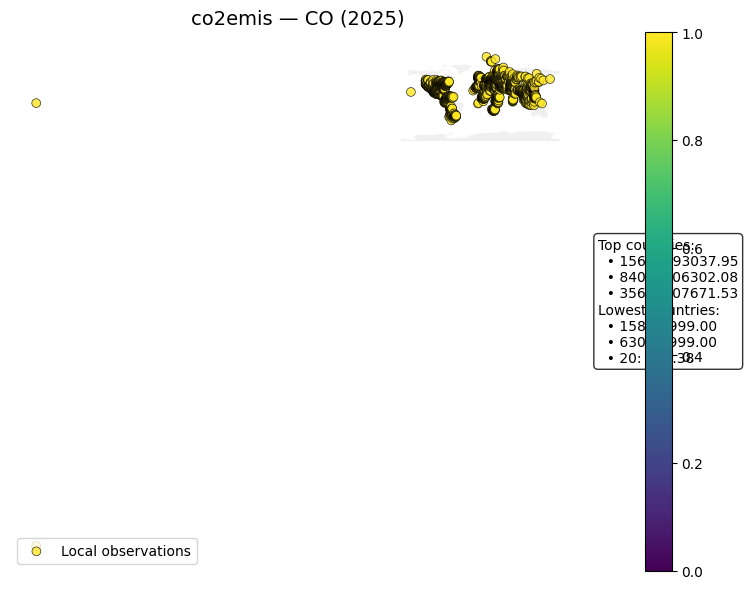

,Country,Score,Source
0,156,9893037.95,World Values Survey
1,840,5006302.08,World Values Survey
2,356,2407671.53,World Values Survey
3,643,1732026.78,World Values Survey
4,392,1135886.25,World Values Survey
5,276,727972.84,World Values Survey
6,364,661710.15,World Values Survey
7,410,620302.39,World Values Survey
8,360,563324.54,World Values Survey
9,124,544894.20,World Values Survey


,Country,ParentCountry,Score
0,2.0 — 156.0,156.0,9893037.95
1,2.0 — 156.0,156.0,9893037.95
2,2.0 — 156.0,156.0,9893037.95
3,2.0 — 156.0,156.0,9893037.95
4,2.0 — 156.0,156.0,9893037.95
5,2.0 — 156.0,156.0,9893037.95
6,2.0 — 156.0,156.0,9893037.95
7,2.0 — 156.0,156.0,9893037.95
8,2.0 — 156.0,156.0,9893037.95
9,2.0 — 156.0,156.0,9893037.95


In [4]:
def render_culture_map(
    year: int,
    question_group: str,
    question: str,
    *,
    include_locations: bool = True,
) -> None:
    year = int(year)
    fig, ax = render_static_culture_map(
        dataset,
        year,
        question_group,
        question,
        include_locations=include_locations,
    )
    display(fig)
    plt.close(fig)
    country_subset = dataset.get_map_view("country", year, question_group, question)
    if not country_subset.empty:
        display(
            country_subset
            .sort_values("Score", ascending=False)[["Country", "Score", "Source"]]
            .reset_index(drop=True)
            .head(10)
        )
    location_subset = dataset.get_map_view("location", year, question_group, question)
    if include_locations and not location_subset.empty:
        display(
            location_subset
            .sort_values("Score", ascending=False)[["Country", "ParentCountry", "Score"]]
            .reset_index(drop=True)
            .head(10)
        )


def display_default_map() -> None:
    default_year = max(dataset.get_years())
    default_group = next(iter(dataset.get_group_questions().keys()))
    default_question = dataset.get_group_questions()[default_group][0]
    display(
        Markdown(
            f"Static map for **{default_question}** ({default_group}, {default_year}). "
            "Local observations are plotted as circles."
        )
    )
    render_culture_map(default_year, default_group, default_question)


if __name__ == "__main__":
    display_default_map()


## 5. Comparison matrix with adjustable weights

Use the widget below to select any combination of countries and tune the relative importance of each survey question. The accordion exposes per-question weights while the dashboard summarises question-level and group-level standings.

In [5]:
if widgets is None:
    display(Markdown('ipywidgets is not available; interactive dashboards are disabled.'))
else:
    class ComparisonDashboard:
        def __init__(self, dataset: CulturalDataset):
            self.dataset = dataset
            self.weight_controls: Dict[str, Dict[str, widgets.FloatSlider]] = {}

            self.country_select = widgets.SelectMultiple(
                options=dataset.get_countries(),
                value=tuple(dataset.get_countries()[:3]),
                description='Countries',
                layout=widgets.Layout(width='300px', height='200px'),
            )
            self.year_dropdown = widgets.Dropdown(
                options=dataset.get_years(),
                value=max(dataset.get_years()),
                description='Year',
            )
            group_options = ['All Groups'] + list(dataset.get_group_questions().keys())
            self.group_dropdown = widgets.Dropdown(
                options=group_options,
                value='All Groups',
                description='Focus',
            )
            self.output_table = widgets.Output()
            self.output_heatmap = widgets.Output()

            weight_children = []
            for group, questions in dataset.get_group_questions().items():
                sliders = []
                controls = {}
                for question in questions:
                    slider = widgets.FloatSlider(
                        value=1.0,
                        min=0.0,
                        max=2.0,
                        step=0.05,
                        description=question[:22] + ('…' if len(question) > 22 else ''),
                        readout=True,
                        readout_format='.2f',
                        style={'description_width': 'initial'},
                    )
                    sliders.append(slider)
                    controls[question] = slider
                self.weight_controls[group] = controls
                weight_children.append(widgets.VBox(sliders))
            self.weight_accordion = widgets.Accordion(children=weight_children)
            for idx, group in enumerate(dataset.get_group_questions().keys()):
                self.weight_accordion.set_title(idx, group)

            self.country_select.observe(self._update_dashboard, names='value')
            self.year_dropdown.observe(self._update_dashboard, names='value')
            self.group_dropdown.observe(self._update_dashboard, names='value')
            for controls in self.weight_controls.values():
                for slider in controls.values():
                    slider.observe(self._update_dashboard, names='value')

            self.container = widgets.VBox([
                widgets.HBox([self.country_select, widgets.VBox([self.year_dropdown, self.group_dropdown])]),
                self.weight_accordion,
                self.output_table,
                self.output_heatmap,
            ])
            self._update_dashboard()

        def _collect_weights(self) -> Dict[Tuple[str, str], float]:
            weights = {}
            for group, controls in self.weight_controls.items():
                for question, slider in controls.items():
                    weights[(group, question)] = slider.value
            return weights

        def _update_dashboard(self, *_):
            if not self.country_select.value:
                return
            countries = list(self.country_select.value)
            year = self.year_dropdown.value
            group_focus = self.group_dropdown.value
            weights = self._collect_weights()

            with self.output_table:
                clear_output(wait=True)
                try:
                    matrix = self.dataset.get_question_matrix(countries, year, group_focus)
                    display(Markdown("### Question-level comparison"))
                    display(matrix.round(3))
                    if group_focus != 'All Groups':
                        focus_weights = {q: weights[(group_focus, q)] for q in matrix.index}
                        summary = (
                            matrix.mul(pd.Series(focus_weights), axis=0).sum(axis=0) /
                            max(sum(focus_weights.values()), 1e-9)
                        )
                        display(Markdown("**Weighted group score (per country):**"))
                        display(summary.round(3).to_frame(name='Score'))
                    else:
                        aggregated = self.dataset.compute_weighted_group_scores(countries, year, weights)
                        display(Markdown("### Group-level weighted scores"))
                        display(aggregated.round(3))
                except Exception as exc:
                    display(Markdown(f"**Error:** {exc}"))

            with self.output_heatmap:
                clear_output(wait=True)
                try:
                    aggregated = self.dataset.compute_weighted_group_scores(countries, year, weights).fillna(np.nan)
                    fig, ax = plt.subplots(figsize=(8, max(3, len(aggregated) * 0.6)))
                    data = np.ma.masked_invalid(aggregated.values.astype(float))
                    im = ax.imshow(data, aspect="auto", cmap="viridis", vmin=0, vmax=1)
                    ax.set_xticks(range(len(aggregated.columns)))
                    ax.set_xticklabels(list(aggregated.columns), rotation=45, ha="right")
                    ax.set_yticks(range(len(aggregated.index)))
                    ax.set_yticklabels(list(aggregated.index))
                    ax.set_xlabel("Question Group")
                    ax.set_ylabel("Country")
                    ax.set_title("Weighted cultural proximity")
                    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Score")
                    fig.tight_layout()
                    display(fig)
                    plt.close(fig)
                except Exception as exc:
                    display(Markdown(f"**Unable to render heatmap:** {exc}"))
        def add_from_map(self, entity_name: str, entity_type: str = "country") -> None:
            try:
                self.dataset.ensure_entity_available(entity_name, entity_type)
            except ValueError as exc:
                with self.output_table:
                    clear_output(wait=True)
                    display(Markdown(f"**Map selection error:** {exc}"))
                return
            options = list(self.country_select.options)
            if entity_name not in options:
                options.append(entity_name)
                options.sort(key=str.lower)
                self.country_select.options = options
            current = list(self.country_select.value)
            if entity_name not in current:
                current.append(entity_name)
                self.country_select.value = tuple(current)
            self._update_dashboard()

        def display(self):
            display(self.container)

    comparison_dashboard = ComparisonDashboard(dataset)
    comparison_dashboard.display()

## 6. Family and team survey capture

Record member scores (normalised 0–1) for a family or team group below. After adding members you can finalise the profile to discover the nearest national culture using Euclidean similarity across the shared question space.

In [6]:
if widgets is None:
    display(Markdown('ipywidgets is not available; group survey widget is disabled.'))
else:
    class GroupSurveyWidget:
        def __init__(self, dataset: CulturalDataset, manager: GroupManager):
            self.dataset = dataset
            self.manager = manager
            self.output = widgets.Output()
            self._build_widgets()

        def _build_widgets(self):
            self.group_type = widgets.ToggleButtons(
                options=[('Family', 'family'), ('Team', 'team')],
                description='Group type',
            )
            self.group_name = widgets.Text(description='Group name', placeholder='e.g. Rivera Family')
            self.member_name = widgets.Text(description='Member name', placeholder='e.g. Ana')
            self.year_dropdown = widgets.Dropdown(
                options=self.dataset.get_years(),
                value=max(self.dataset.get_years()),
                description='Ref. year',
            )
            self.question_sliders: Dict[Tuple[str, str], widgets.FloatSlider] = {}
            slider_boxes = []
            for group, questions in self.dataset.get_group_questions().items():
                sliders = []
                for question in questions:
                    slider = widgets.FloatSlider(
                        value=0.5,
                        min=0.0,
                        max=1.0,
                        step=0.01,
                        description=question[:28] + ('…' if len(question) > 28 else ''),
                        style={'description_width': 'initial'},
                        readout=True,
                        readout_format='.2f',
                    )
                    self.question_sliders[(group, question)] = slider
                    sliders.append(slider)
                slider_boxes.append(widgets.VBox([widgets.HTML(f"<h4>{group}</h4>")] + sliders))
            self.slider_accordion = widgets.Accordion(children=slider_boxes)
            for idx, group in enumerate(self.dataset.get_group_questions().keys()):
                self.slider_accordion.set_title(idx, group)

            self.add_member_button = widgets.Button(description='Add member responses', button_style='success')
            self.finalise_button = widgets.Button(description='Finalise & match', button_style='primary')
            self.add_member_button.on_click(self._handle_add_member)
            self.finalise_button.on_click(self._handle_finalise)

            self.form = widgets.VBox([
                widgets.HBox([self.group_type, self.group_name, self.member_name, self.year_dropdown]),
                self.slider_accordion,
                widgets.HBox([self.add_member_button, self.finalise_button]),
                self.output,
            ])

        def _collect_scores(self) -> Dict[Tuple[str, str], float]:
            return {key: slider.value for key, slider in self.question_sliders.items()}

        def _handle_add_member(self, _):
            try:
                responses = self._collect_scores()
                self.manager.add_member(
                    group_name=self.group_name.value,
                    member_name=self.member_name.value,
                    responses=responses,
                    group_type=self.group_type.value,
                    reference_year=self.year_dropdown.value,
                )
                with self.output:
                    clear_output(wait=True)
                    display(Markdown(f"✅ Added survey for **{self.member_name.value}**."))
                self.member_name.value = ''
            except Exception as exc:
                with self.output:
                    clear_output(wait=True)
                    display(Markdown(f"⚠️ {exc}"))

        def _handle_finalise(self, _):
            try:
                group_name = self.group_name.value
                profile = self.manager.compute_group_profile(group_name)
                match_df = self.manager.match_closest_country(group_name)
                with self.output:
                    clear_output(wait=True)
                    display(Markdown(f"### Profile for **{group_name}**"))
                    display(profile.round(3).to_frame(name='Average score'))
                    display(Markdown("### Closest national cultures"))
                    display(match_df.head(5).round(3))
            except Exception as exc:
                with self.output:
                    clear_output(wait=True)
                    display(Markdown(f"⚠️ {exc}"))

        def display(self):
            display(self.form)

    group_widget = GroupSurveyWidget(dataset, group_manager)
    group_widget.display()

## 8. Backend helper verification
Quick smoke-tests ensure the lightweight service behaves as expected when called directly from Python.


## 9. OpenAI cultural insights

## 10. Adding retrospective or future data

In [9]:
def add_future_record(
    country: str,
    iso3: str,
    latitude: float,
    longitude: float,
    year: int,
    source: str,
    question_group: str,
    question: str,
    score: float,
    entity_type: str = 'country',
    parent_country: Optional[str] = None,
) -> None:
    question_code = dataset.get_question_code(question_group, question)
    record = pd.DataFrame([
        {
            'Country': country,
            'ISO3': iso3,
            'Latitude': latitude,
            'Longitude': longitude,
            'Year': year,
            'Source': source,
            'QuestionGroup': question_group,
            'Question': question,
            'QuestionCode': question_code,
            'Score': score,
            'EntityType': entity_type,
            'ParentCountry': parent_country or country,
        }
    ])
    if entity_type == 'country':
        dataset.country_data = pd.concat([dataset.country_data, record], ignore_index=True)
        dataset.data = dataset.country_data.copy()
    elif entity_type == 'location':
        dataset.location_data = pd.concat([dataset.location_data, record], ignore_index=True)
        dataset.location_lookup[country] = dataset.location_data[dataset.location_data['Country'] == country]
    else:
        raise ValueError(f"Unsupported entity type '{entity_type}'.")
    dataset._refresh_metadata()


add_future_record(
    country='Futuria',
    iso3='FTR',
    latitude=12.34,
    longitude=56.78,
    year=2025,
    source='EVS',
    question_group=list(dataset.get_group_questions().keys())[0],
    question=dataset.get_group_questions()[list(dataset.get_group_questions().keys())[0]][0],
    score=0.67,
)
display(Markdown("Appended a placeholder future data point for Futuria (2025)."))
dataset.data = dataset.data[dataset.data['Country'] != 'Futuria']
dataset.country_data = dataset.country_data[dataset.country_data['Country'] != 'Futuria']
dataset._refresh_metadata()


Appended a placeholder future data point for Futuria (2025).